In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.insert(1, '/home/chene5/ENVI_new_copy/scenvi')
from utils import *
from ENVI import *


2024-06-04 16:22:14.318204: W external/xla/xla/service/gpu/nvptx_compiler.cc:760] The NVIDIA driver's CUDA version is 12.2 which is older than the ptxas CUDA version (12.4.131). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


In [2]:
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
import seaborn as sns

import sklearn.neighbors
import scipy.sparse
import umap.umap_ as umap

/home/chene/miniconda3/envs/envi/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
st_data = sc.read_h5ad('/data/peer/chene5/scenvi/st_data.h5ad')
sc_data = sc.read_h5ad('/data/peer/chene5/scenvi/sc_data.h5ad')

# train test split of spatial data
split = st_data.shape[0] // 10 * 8

train_idx = np.random.choice(st_data.shape[0], split, replace=False)
test_idx = np.setdiff1d(np.arange(st_data.shape[0]), train_idx)

train_st_data, test_st_data = st_data[train_idx], st_data[test_idx]

In [4]:
envi_model = ENVI(spatial_data = train_st_data, sc_data = sc_data)

/home/chene/ENVI_new_copy/scenvi/ENVI.py:87: ImplicitModificationWarning: Setting element `.layers['log']` of view, initializing view as actual.
  self.spatial_data.layers["log"] = np.log(self.spatial_data.X + log_input)


Computing Niche Matrices


/home/chene/ENVI_new_copy/scenvi/utils.py:377: ImplicitModificationWarning: Setting element `.layers['scaled_log']` of view, initializing view as actual.
  spatial_data.layers["scaled_log"] = ((spatial_data.layers["log"] - gene_mins) / (gene_maxs - gene_mins) * 2 - 1) / sqrt(n_niche_genes) #divide by n_niche_genes


Initializing CVAE
Finished Initializing ENVI


In [5]:
envi_model.start_train()

In [6]:
i,j = np.random.randint(0,envi_model.spatial_data.obsm['scaled_niche'].shape[0],2)

S2(envi_model.spatial_data.obsm['scaled_niche'][i],envi_model.spatial_data.obsm['scaled_niche'][j], 1e-2, True)


Array(0.3172094, dtype=float32)

In [7]:
# prep test
test_st_data.layers['log'] = np.log(test_st_data.X + envi_model.log_input)
test_min, test_max = compute_niche(test_st_data, envi_model.n_niche_genes, envi_model.k_nearest, envi_model.spatial_key, envi_model.batch_key)

/tmp/ipykernel_69145/1492172425.py:2: ImplicitModificationWarning: Setting element `.layers['log']` of view, initializing view as actual.
  test_st_data.layers['log'] = np.log(test_st_data.X + envi_model.log_input)


In [8]:
# test inference
envi_model.infer_niche_x(test_st_data, "spatial")
envi_model.infer_niche_x(envi_model.spatial_data, "spatial")

pretrain_mean_test_OT, pretrain_test_OTs = envi_model.batched_S2(test_st_data.obsm['scaled_niche'],test_st_data.obsm['inferred_scaled_niche'], 1e-2, True)
pretrain_mean_test_OT # Array(1.084708, dtype=float32)

Array(0.87742645, dtype=float32)

In [22]:
pretrain_mean_train_OT, pretrain_train_OTs = envi_model.batched_S2(envi_model.spatial_data.obsm['scaled_niche'],envi_model.spatial_data.obsm['inferred_scaled_niche'], 1e-2, True)
pretrain_mean_train_OT # Array(0.9498272, dtype=float32)

Array(0.8777035, dtype=float32)

In [23]:
envi_model.continue_train(training_steps = 10000)

 spatial: -6.282e-01 sc: -7.430e-01 niche: 1.193e-01 kl: 6.671e-01: 100%|██████████| 10000/10000 [04:31<00:00, 36.81it/s]
/home/chene/ENVI_new_copy/scenvi/ENVI.py:820: ImplicitModificationWarning: Setting element `.obsm['envi_latent']` of view, initializing view as actual.
  self.sc_data.obsm["envi_latent"] = self.encode(


In [24]:
# test inference
envi_model.infer_niche_x(test_st_data, "spatial")
envi_model.infer_niche_x(envi_model.spatial_data, "spatial")

posttrain_mean_test_OT, posttrain_test_OTs = envi_model.batched_S2(test_st_data.obsm['scaled_niche'],test_st_data.obsm['inferred_scaled_niche'], 1e-2, True)
posttrain_mean_test_OT # Array(0.0455406, dtype=float32)

Array(0.13160126, dtype=float32)

In [25]:
posttrain_mean_train_OT, posttrain_train_OTs = envi_model.batched_S2(envi_model.spatial_data.obsm['scaled_niche'],envi_model.spatial_data.obsm['inferred_scaled_niche'], 1e-2, True)
posttrain_mean_train_OT # Array(0.05396247, dtype=float32)

Array(0.11927313, dtype=float32)

In [26]:
# test S2 between random inferred
rand_mean, rands = envi_model.batched_S2(envi_model.spatial_data.obsm['inferred_scaled_niche'][:100],envi_model.spatial_data.obsm['inferred_scaled_niche'][100:200], 1e-2, True)
rand_mean # Array(0.02536068, dtype=float32)

Array(0.04844595, dtype=float32)

In [27]:
# test S2 between random actual
rand_mean, rands = envi_model.batched_S2(envi_model.spatial_data.obsm['scaled_niche'][:100],envi_model.spatial_data.obsm['scaled_niche'][100:200], 1e-2, True)
rand_mean # Array(0.12950826, dtype=float32)


Array(0.27666268, dtype=float32)

In [31]:
# save
envi_model.spatial_data.write('/data/peer/chene/scenvi/posttrain/posttrain_train_st_data.h5ad')
test_st_data.write('/data/peer/chene/scenvi/posttrain/posttrain_test_st_data.h5ad')
envi_model.sc_data.write('/data/peer/chene/scenvi/posttrain/posttrain_sc_data.h5ad')

IORegistryError: No method registered for writing <class 'jaxlib.xla_extension.ArrayImpl'> into <class 'h5py._hl.group.Group'>

## Explore output


In [33]:
(envi_model.spatial_data.obsm["inferred_niche"].min(), envi_model.spatial_data.obsm["inferred_niche"].max()), (envi_model.spatial_data.obsm["niche"].min(), envi_model.spatial_data.obsm["niche"].max())

((-2.3022476635283975, 4.044930304434553),
 (-2.3025849603864668, 5.784288923192772))

In [34]:
(test_st_data.obsm["inferred_scaled_niche"].min(), test_st_data.obsm["inferred_scaled_niche"].max()), (test_st_data.obsm["scaled_niche"].min(), test_st_data.obsm["scaled_niche"].max())

((-0.062736705, 0.04964247),
 (Array(-0.06274559, dtype=float32), Array(0.0627456, dtype=float32)))

In [35]:
inferred = test_st_data.obsm["inferred_niche"]
actual = test_st_data.obsm["niche"]

In [36]:
train_inferred = envi_model.spatial_data.obsm["inferred_niche"]
train_actual = envi_model.spatial_data.obsm["niche"]

<Axes: >

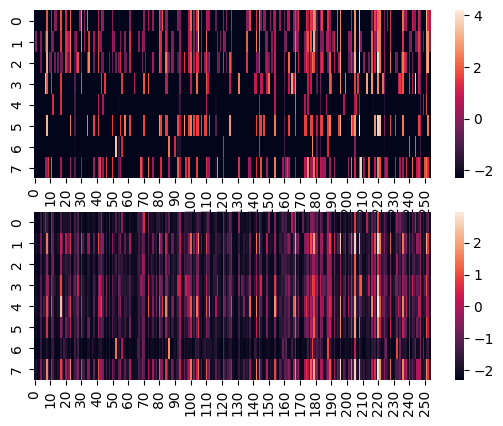

In [37]:
from scipy.optimize import linear_sum_assignment


i=20

cost = np.array([
    [np.linalg.norm(x - y) for x in actual[i]] for y in inferred[i]
])
row_ind, col_ind = linear_sum_assignment(cost)
fig, (ax1, ax2) = plt.subplots(2, 1)
sns.heatmap(actual[i], ax=ax1)
sns.heatmap(inferred[i][col_ind], ax=ax2)


Text(0.5, 1.0, 'Inferred')

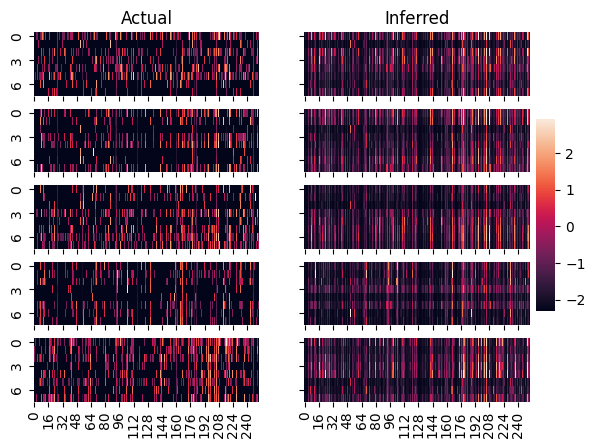

In [38]:
# 5 random actual and inferred train niches 
# using linear sum assignment

idxs = np.random.randint(0,test_st_data.obsm['scaled_niche'].shape[0], 5)

fig, axs = plt.subplots(5, 2, sharex=True, sharey=True)
cbar_ax = fig.add_axes([.91, .3, .03, .4])
for i, ax in enumerate(axs):
    #train_actual[idxs[i]] = jnp.sort(train_actual[idxs[i]], axis=0) # optional sort
    cost = np.array([
        [np.linalg.norm(x - y) for x in train_actual[idxs[i]]] for y in train_inferred[idxs[i]]
    ])
    reordering = linear_sum_assignment(cost)[1]
    sns.heatmap(train_actual[idxs[i]], ax=ax[0], cbar=i == 0, cbar_ax=None if i else cbar_ax)
    sns.heatmap(train_inferred[idxs[i]][reordering], ax=ax[1], cbar=i == 0, cbar_ax=None if i else cbar_ax) 
axs[0][0].set_title('Actual')
axs[0][1].set_title('Inferred')


Text(0.5, 1.0, 'Inferred')

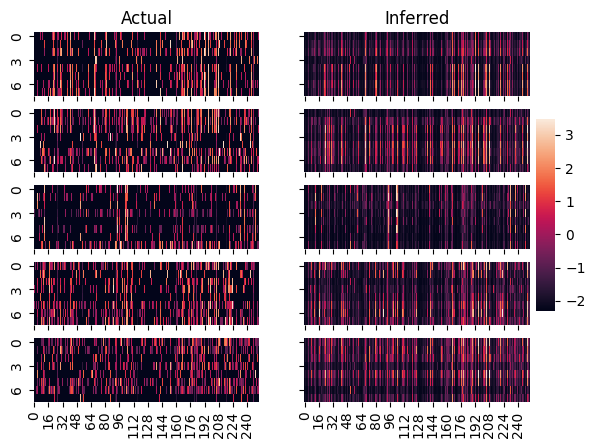

In [39]:
# 5 random actual and inferred test niches 
# using linear sum assignment

idxs = np.random.randint(0,test_st_data.obsm['scaled_niche'].shape[0], 5)

fig, axs = plt.subplots(5, 2, sharex=True, sharey=True)
cbar_ax = fig.add_axes([.91, .3, .03, .4])
for i, ax in enumerate(axs):
    #actual[idxs[i]] = jnp.sort(actual[idxs[i]], axis=0) # optional sort
    cost = np.array([
        [np.linalg.norm(x - y) for x in actual[idxs[i]]] for y in inferred[idxs[i]]
    ])
    reordering = linear_sum_assignment(cost)[1]
    sns.heatmap(actual[idxs[i]], ax=ax[0], cbar=i == 0, cbar_ax=None if i else cbar_ax)
    sns.heatmap(inferred[idxs[i]][reordering], ax=ax[1], cbar=i == 0, cbar_ax=None if i else cbar_ax) 
axs[0][0].set_title('Actual')
axs[0][1].set_title('Inferred')
